In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим наши данные:

In [4]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим наши модели, включая улучшенную "простую" модель с улучшенными гиперпараметрами:

In [5]:
simple_model = tf.keras.models.load_model('ready_models/simple_model_tuned.keras')
inception_v3 = tf.keras.models.load_model('ready_models/inception_v3.keras')
resnet_50_v2 = tf.keras.models.load_model('ready_models/resnet_50_v2.keras')
mobile_net_v2 = tf.keras.models.load_model('ready_models/mobile_net_v2.keras')
xception = tf.keras.models.load_model('ready_models/xception.keras')
nas_net_mobile = tf.keras.models.load_model('ready_models/nas_net_mobile.keras')

simple_model._name = 'simple_model'
inception_v3._name = 'inception_v3'
resnet_50_v2._name = 'resnet_50_v2'
mobile_net_v2._name = 'mobile_net_v2'
xception._name = 'xception'
nas_net_mobile._name = 'nas_net_mobile'

Попробуем все комбинации из пяти моделей:

In [13]:
models = [simple_model, inception_v3, resnet_50_v2, mobile_net_v2, xception, nas_net_mobile]
model_names = [m._name for m in models]

import itertools

for combination in itertools.combinations(model_names, 5):
    print(f"testing combination: {combination}")
    model_input = tf.keras.Input(shape=(256, 256, 3))
    model_outputs = [model(model_input) for model in models if model._name in combination]
    ensemble_output = tf.keras.layers.Average()(model_outputs)
    ensemble_model_avg = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
    
    ensemble_model_avg.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                               metrics=['accuracy'])
    print(ensemble_model_avg.evaluate(test_ds))

testing combination: ('simple_model', 'inception_v3', 'resnet_50_v2', 'mobile_net_v2', 'xception')


2024-04-28 15:01:36.879858: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-28 15:01:37.112213: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-28 15:01:43.684327: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-04-28 15:01:49.060594: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.88GiB with freed_by_count=0. The caller 

93/93 [==============================] - 54s 387ms/step - loss: 0.7719 - accuracy: 0.8347
[0.7718690633773804, 0.8346773982048035]
testing combination: ('simple_model', 'inception_v3', 'resnet_50_v2', 'mobile_net_v2', 'nas_net_mobile')
93/93 [==============================] - 39s 327ms/step - loss: 0.7973 - accuracy: 0.8317
[0.7973307371139526, 0.8316532373428345]
testing combination: ('simple_model', 'inception_v3', 'resnet_50_v2', 'xception', 'nas_net_mobile')
93/93 [==============================] - 47s 422ms/step - loss: 0.9039 - accuracy: 0.7977
[0.9038740396499634, 0.7977150678634644]
testing combination: ('simple_model', 'inception_v3', 'mobile_net_v2', 'xception', 'nas_net_mobile')
93/93 [==============================] - 43s 380ms/step - loss: 0.8200 - accuracy: 0.8196
[0.820000171661377, 0.819556474685669]
testing combination: ('simple_model', 'resnet_50_v2', 'mobile_net_v2', 'xception', 'nas_net_mobile')
93/93 [==============================] - 46s 406ms/step - loss: 0.7972 

Сравним с результатом при объединении всех щести моделей:

In [14]:
models = [simple_model, inception_v3, resnet_50_v2, mobile_net_v2, xception, nas_net_mobile]
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model_avg = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model_avg.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['accuracy'])
ensemble_model_avg.evaluate(test_ds)

93/93 [==============================] - 54s 474ms/step - loss: 0.7968 - accuracy: 0.8306


[0.7967886924743652, 0.8306451439857483]

Теперь попробуем все возможные комбинации из четырех моделей, которые включают нашу \
самую сильную модель - mobile_net_v2

In [15]:
models = [simple_model, inception_v3, resnet_50_v2, mobile_net_v2, xception, nas_net_mobile]
model_names = [m._name for m in models]

import itertools

for combination in itertools.combinations(model_names, 4):
    if 'mobile_net_v2' not in combination:
        continue
    print(f"testing combination: {combination}")
    model_input = tf.keras.Input(shape=(256, 256, 3))
    model_outputs = [model(model_input) for model in models if model._name in combination]
    ensemble_output = tf.keras.layers.Average()(model_outputs)
    ensemble_model_avg = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
    
    ensemble_model_avg.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                               metrics=['accuracy'])
    print(ensemble_model_avg.evaluate(test_ds))

testing combination: ('simple_model', 'inception_v3', 'resnet_50_v2', 'mobile_net_v2')
93/93 [==============================] - 27s 254ms/step - loss: 0.7681 - accuracy: 0.8353
[0.7681489586830139, 0.835349440574646]
testing combination: ('simple_model', 'inception_v3', 'mobile_net_v2', 'xception')
93/93 [==============================] - 31s 290ms/step - loss: 0.8071 - accuracy: 0.8216
[0.8070749044418335, 0.8215726017951965]
testing combination: ('simple_model', 'inception_v3', 'mobile_net_v2', 'nas_net_mobile')
93/93 [==============================] - 29s 223ms/step - loss: 0.8393 - accuracy: 0.8175
[0.8393092155456543, 0.8175403475761414]
testing combination: ('simple_model', 'resnet_50_v2', 'mobile_net_v2', 'xception')
93/93 [==============================] - 32s 316ms/step - loss: 0.7664 - accuracy: 0.8364
[0.7664243578910828, 0.8363575339317322]
testing combination: ('simple_model', 'resnet_50_v2', 'mobile_net_v2', 'nas_net_mobile')
93/93 [==============================] - 31s 2

Похоже, что наилучший показатель мы получаем при комбинации четырех моделей - \
simple_model, resnet_50_v2, mobile_net_v2, xception. Сохраним отдельно эту модель.

In [16]:
models = [simple_model, resnet_50_v2, mobile_net_v2, xception]
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model_avg = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model_avg.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['accuracy'])

ensemble_model_avg.save('ready_models/ensemble_model_avg_tuned.keras')

Построим матрицу ошибок для выбранной модели:

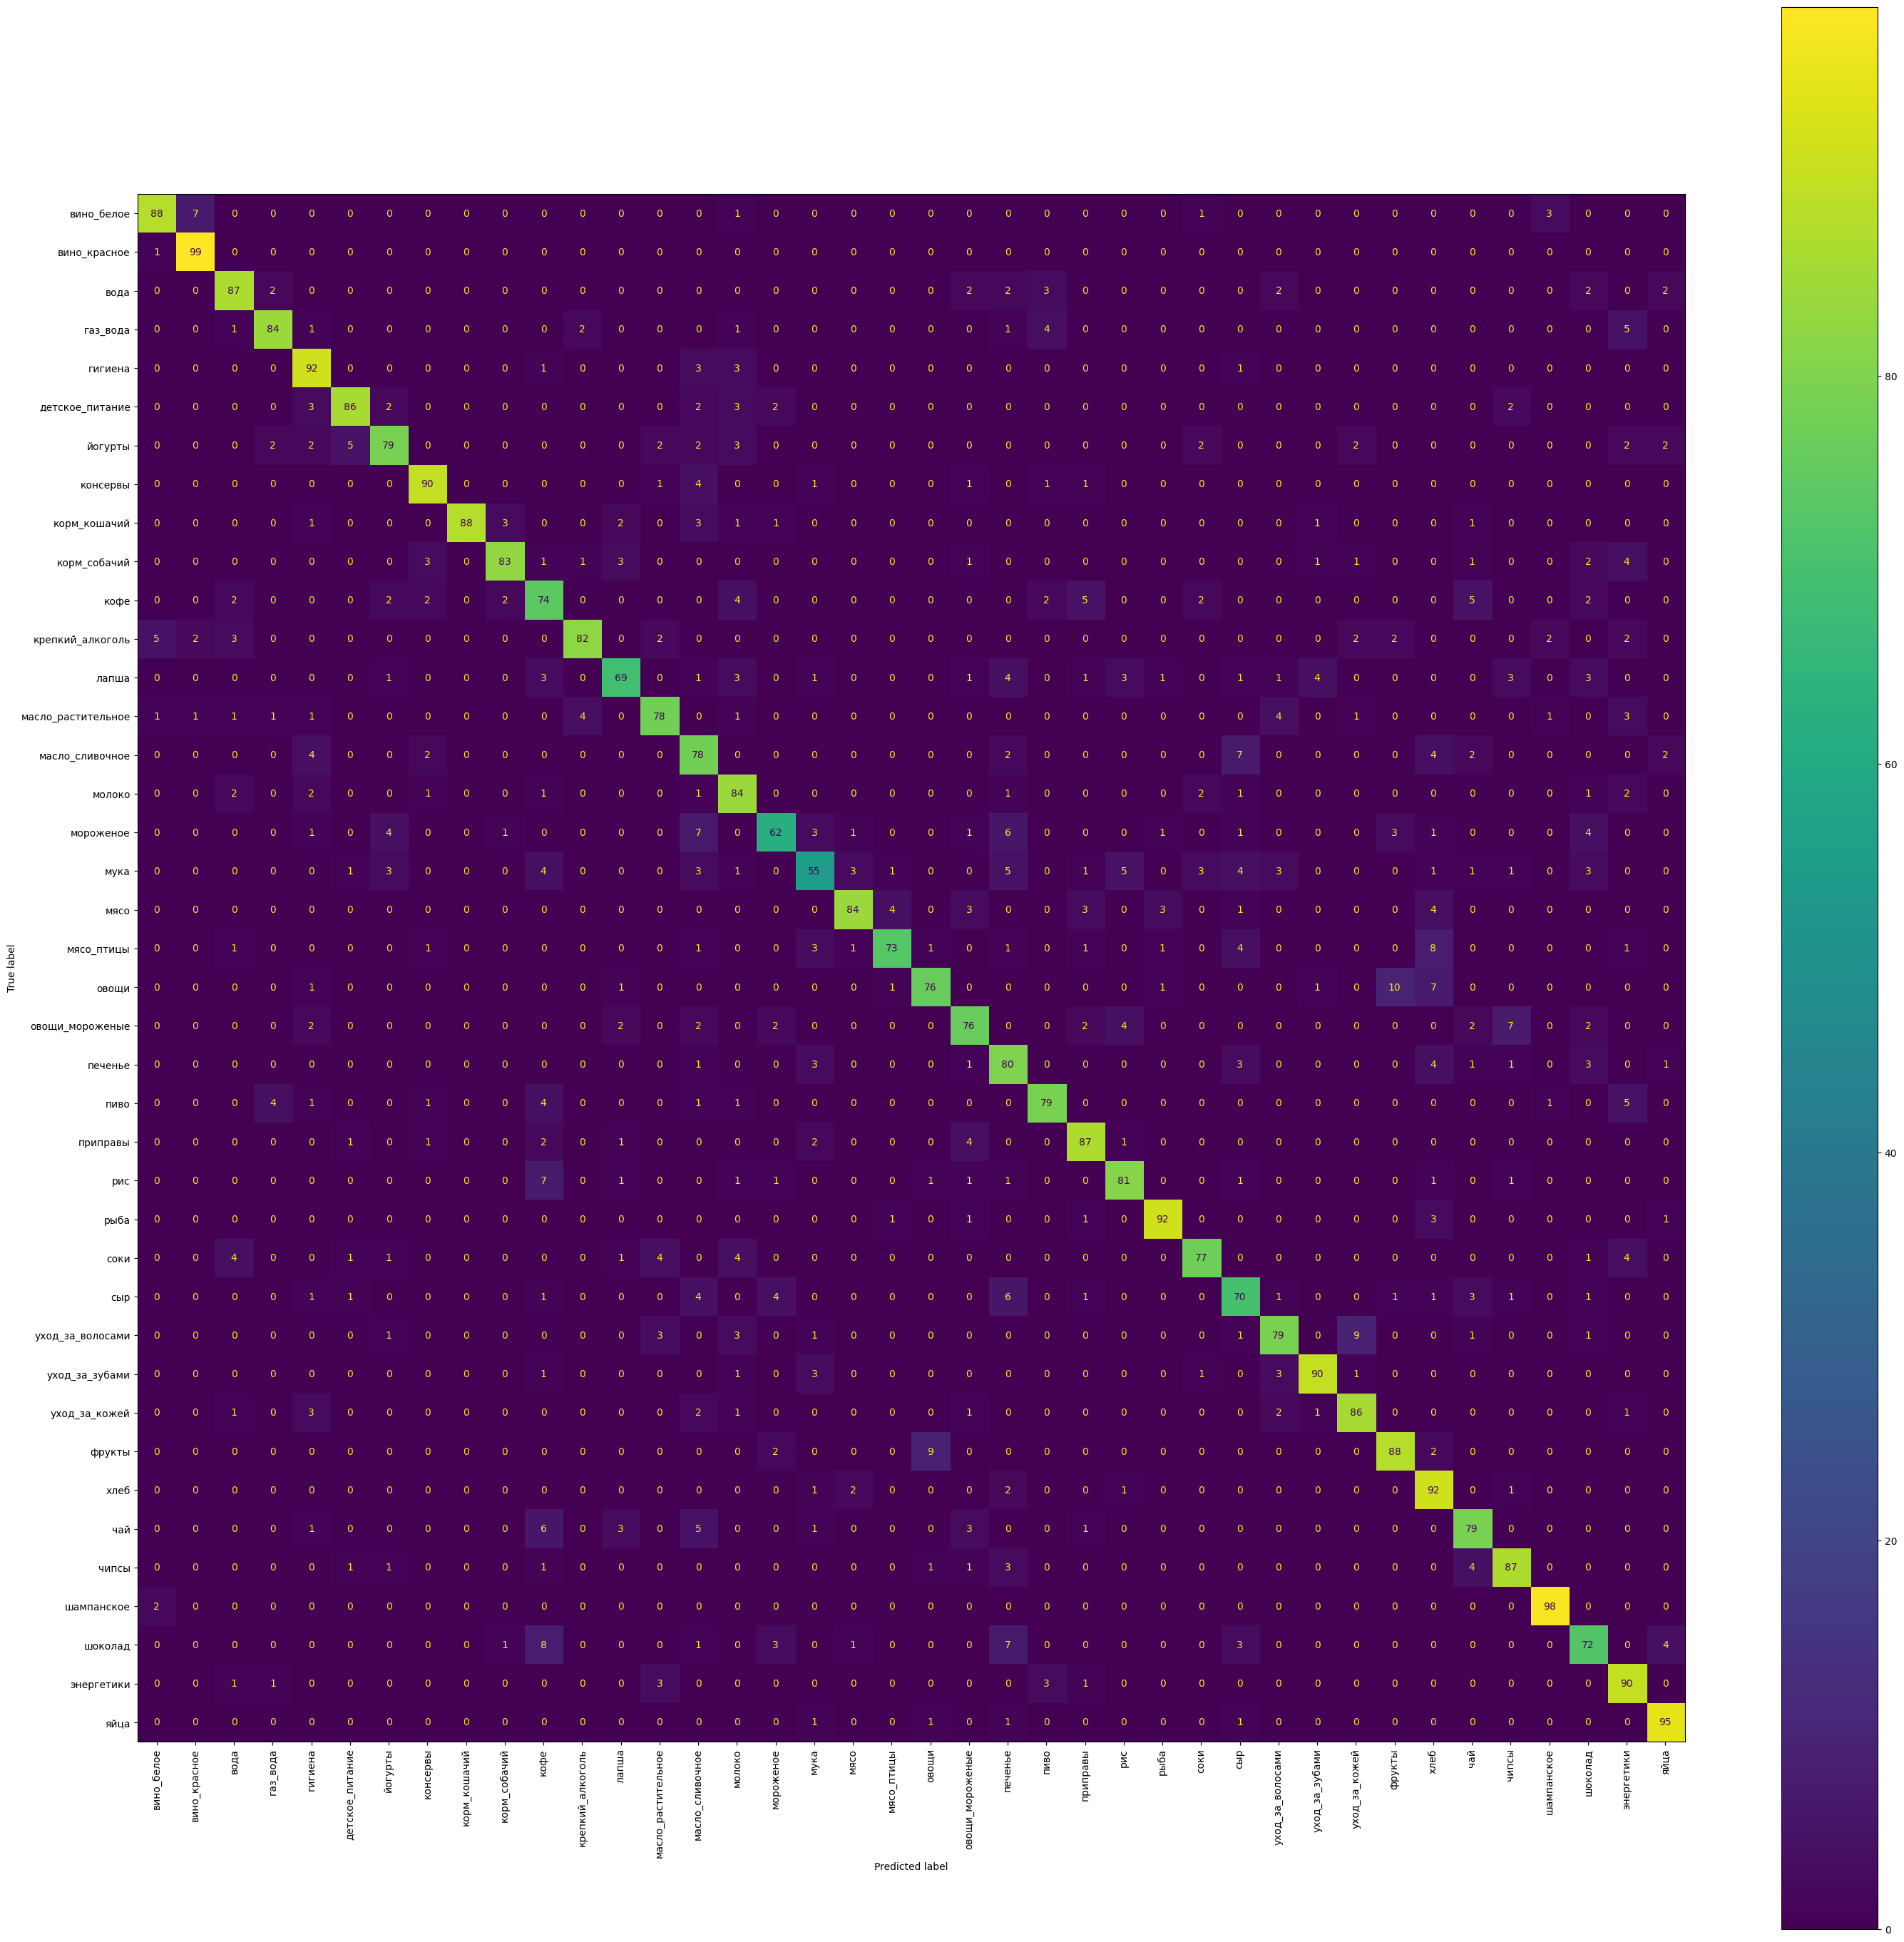

In [16]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(ensemble_model_avg, test_ds, train_ds.class_names)

Для ансамблевой модели типа "стэкинг" мы добавим слой Dropout и увеличим число \
тренировочных эпох на 1:

In [12]:
models = [simple_model, inception_v3, resnet_50_v2, mobile_net_v2, xception, nas_net_mobile]
for model in models:
    model.trainable = False
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
x = tf.keras.layers.Concatenate()(model_outputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
model_output = tf.keras.layers.Dense(40, activation='softmax')(x)
ensemble_model_stacked = tf.keras.Model(inputs=model_input, outputs=model_output)

In [13]:
ensemble_model_stacked.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 simple_model (Sequential)   (None, 40)                   1442792   ['input_2[0][0]']             
                                                                                                  
 inception_v3 (Functional)   (None, 40)                   2287239   ['input_2[0][0]']             
                                                          2                                       
                                                                                                  
 resnet_50_v2 (Functional)   (None, 40)                   2463440   ['input_2[0][0]']       

In [14]:
base_learning_rate = 0.0001
ensemble_model_stacked.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                               loss=tf.keras.losses.CategoricalCrossentropy(),
                               metrics=['accuracy'])

In [15]:
%%time
history = ensemble_model_stacked.fit(train_ds,
                                     epochs=6,
                                     validation_data=val_ds)

Epoch 1/6
433/433 [==============================] - 284s 610ms/step - loss: 2.9753 - accuracy: 0.7265 - val_loss: 2.3573 - val_accuracy: 0.8342
Epoch 2/6
433/433 [==============================] - 260s 600ms/step - loss: 1.2051 - accuracy: 0.9822 - val_loss: 1.0874 - val_accuracy: 0.8450
Epoch 3/6
433/433 [==============================] - 251s 579ms/step - loss: 0.3785 - accuracy: 0.9850 - val_loss: 0.7847 - val_accuracy: 0.8406
Epoch 4/6
433/433 [==============================] - 254s 586ms/step - loss: 0.1909 - accuracy: 0.9858 - val_loss: 0.6881 - val_accuracy: 0.8437
Epoch 5/6
433/433 [==============================] - 251s 580ms/step - loss: 0.1273 - accuracy: 0.9870 - val_loss: 0.6586 - val_accuracy: 0.8444
Epoch 6/6
433/433 [==============================] - 253s 584ms/step - loss: 0.0947 - accuracy: 0.9885 - val_loss: 0.6421 - val_accuracy: 0.8481
CPU times: user 22min 38s, sys: 7min 41s, total: 30min 20s
Wall time: 25min 52s


In [16]:
ensemble_model_stacked.evaluate(test_ds)

93/93 [==============================] - 45s 486ms/step - loss: 0.6708 - accuracy: 0.8431


[0.6707847118377686, 0.8430779576301575]

Построим матрицу ашибок для нашей стэкинг-модели:

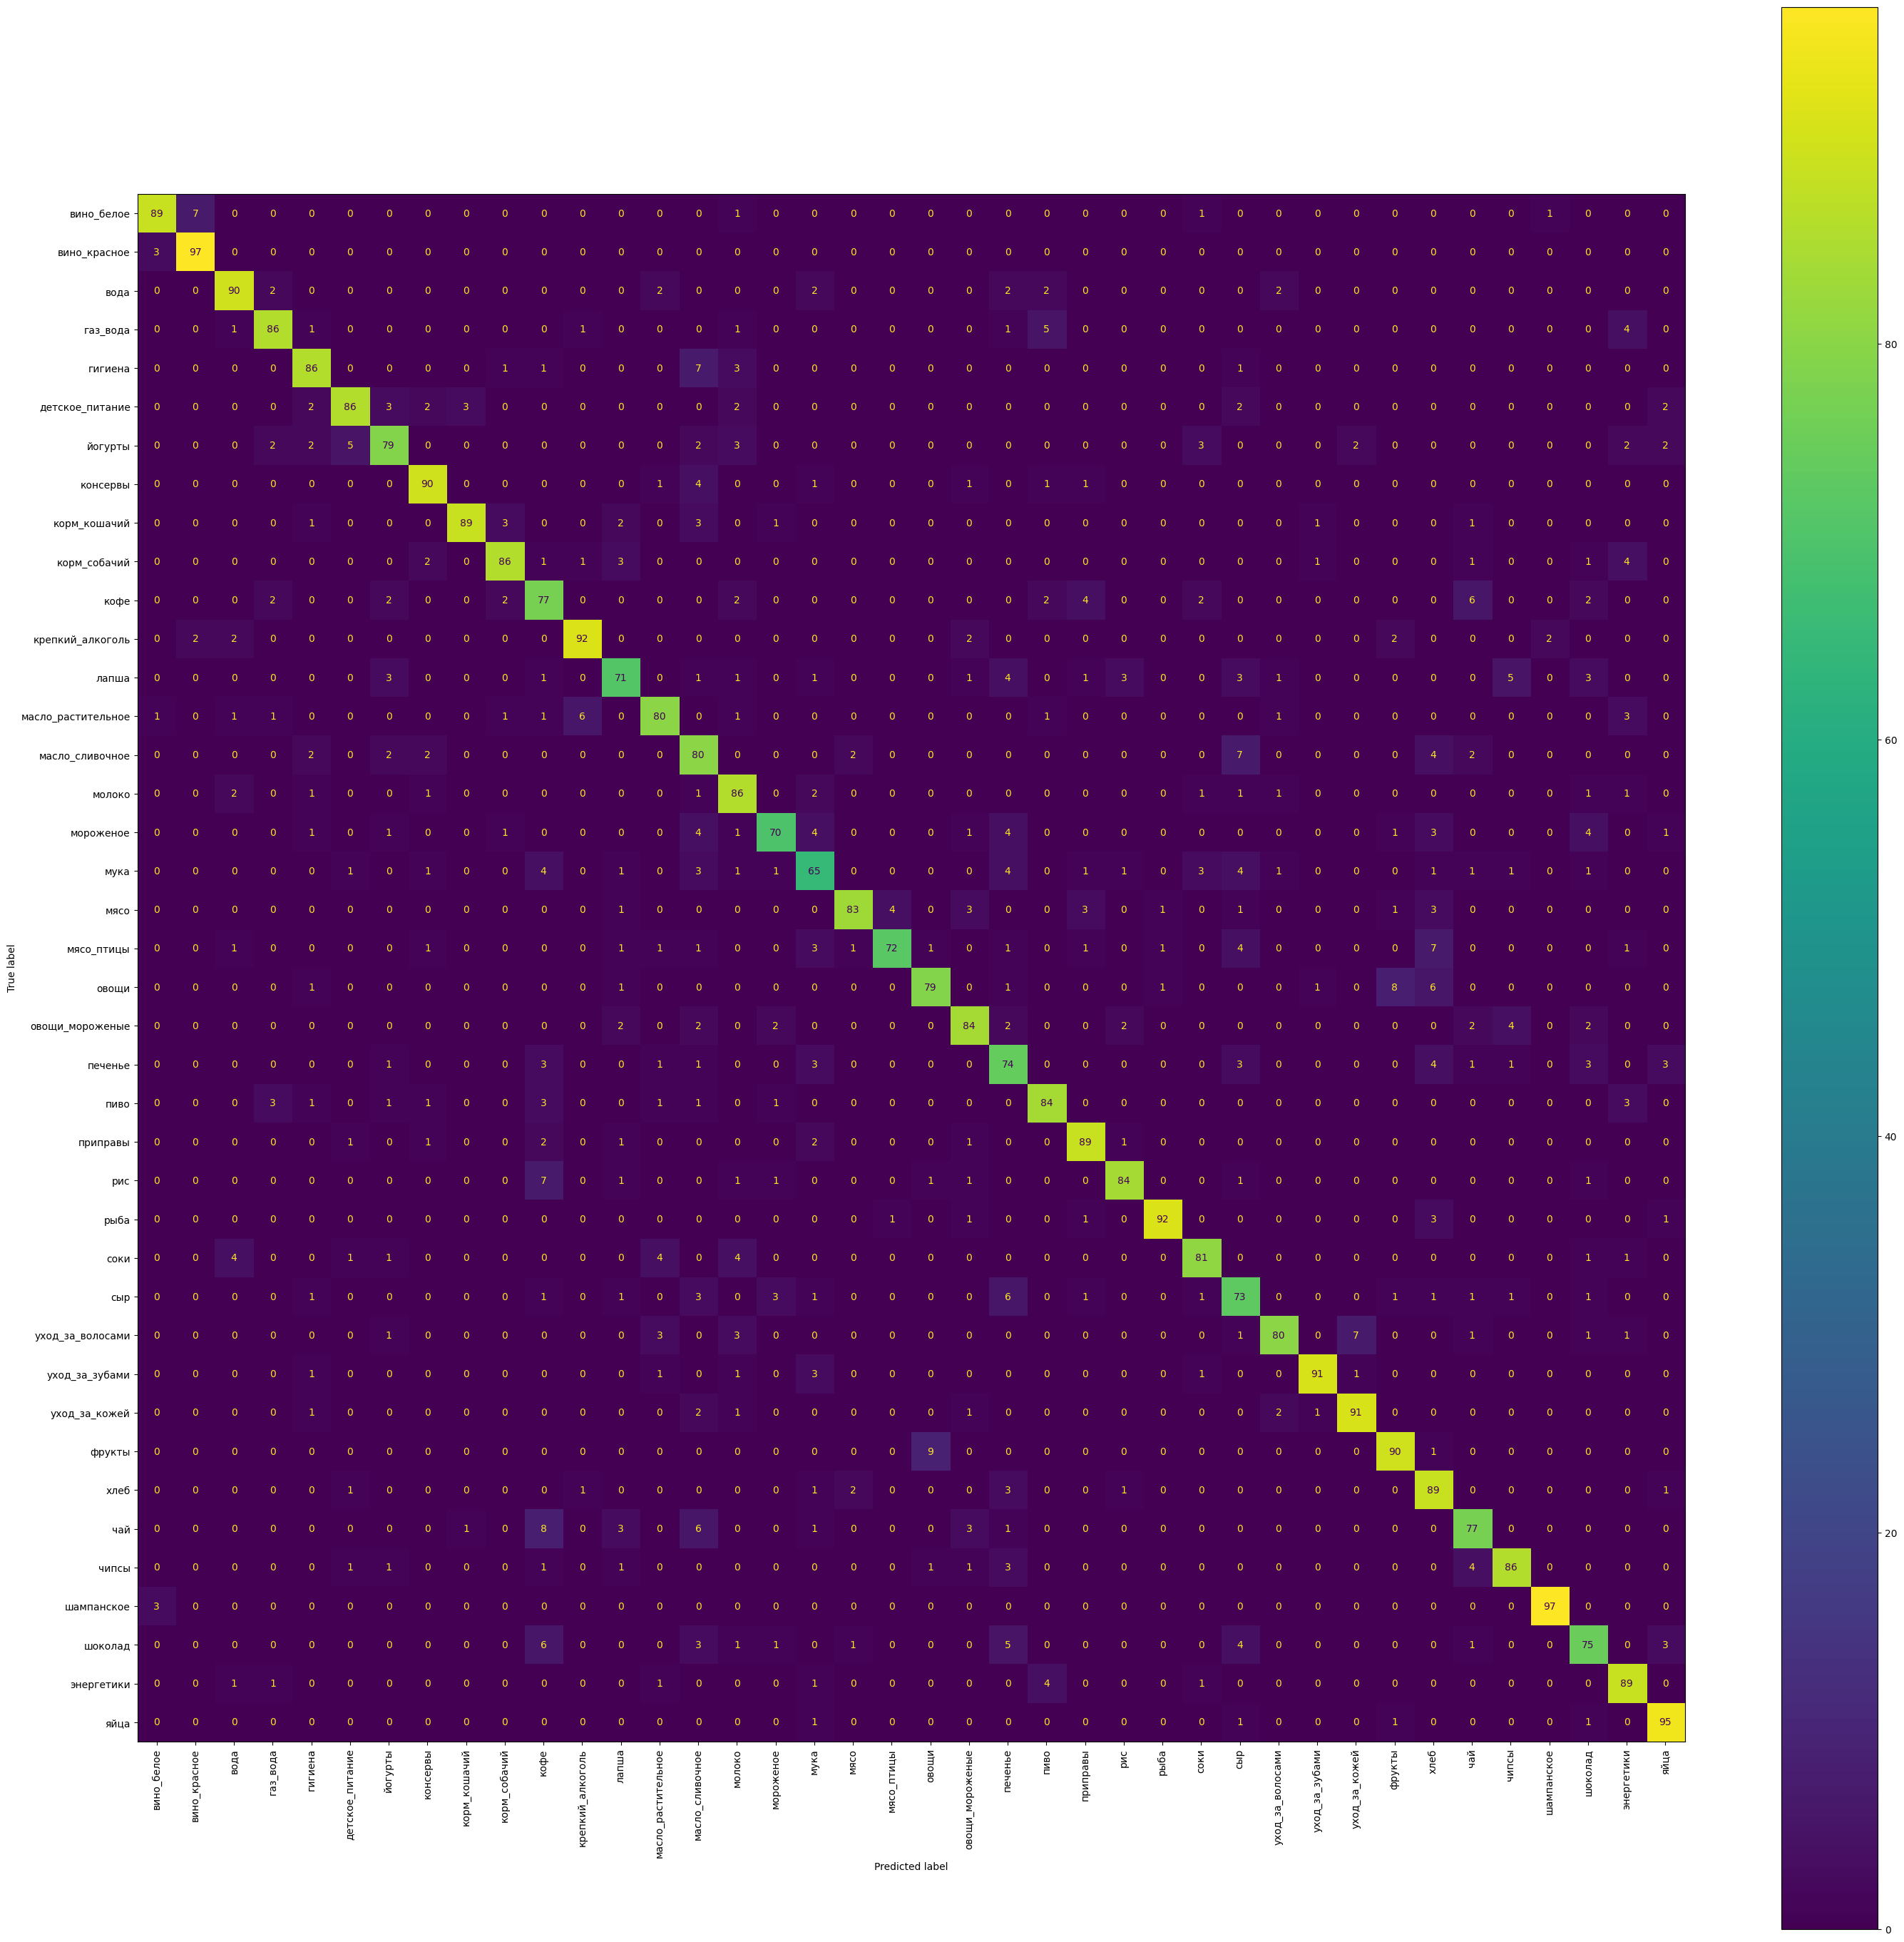

In [17]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(ensemble_model_stacked, test_ds, train_ds.class_names)

Сохраним полученную модель:

In [24]:
ensemble_model_stacked.save('ready_models/ensemble_model_stacked_tuned.keras')